Model 1 -- Baseline + Daily surveys 

- Split all survey data temporally, first half train second half test
- Get all time windows for negative patients (crops of x days, classify as such)

- Get all time windows up to the flu diagnosis for positive patients, leave out the rest?

- Day of diagnosis inclusive?

- Disjoint training and test sets?

- Progressive training with test data?

- Which representations? penultimate layer of cnn window classifier?


window size = 15 days

train -> up to Feb 1, 2020

- Flu positive windows <1% of all windows
- positive samples weighted according to their prevalance in the training set

- 3 layered 1-D CNN


 Average AUC:  0.9368129854780834

 Average accuracy:  0.9775642185845747

 Average precision:  0.11018420238440807

 Average recall:  0.884077380952381

 Average f-1 score:  0.1768313867322393


In [699]:
import numpy as np
import pandas as pd
import os
import datetime

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import precision_recall_curve

import missingno as msno

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
df_survey = pd.read_csv('gates_data_csv/daily_surveys_onehot.csv')
df_baseline = pd.read_csv('gates_data_csv/baseline_screener_onehot.csv')
df_lab = pd.read_csv('gates_data_csv/lab_results_with_triggerdate.csv')

df_survey['timestamp'] = pd.to_datetime(df_survey.timestamp)
df_lab['trigger_datetime'] = pd.to_datetime(df_lab.trigger_datetime)

/homes/gws/melih/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_lab_positive = df_lab.loc[df_lab.result == 'Detected'][['participant_id','trigger_datetime']]

In [4]:
# Adding flu positive information
df_survey = pd.merge(df_survey , df_lab_positive, how='left',on = 'participant_id')

In [5]:
# Strings in temp data, drop for now. Fill nan in recovered_yn and first_report_yn with zeros.
df_survey_model = df_survey.drop(columns = ['Unnamed: 0', 'occurrence', 'recovery_datetime', 'first_sx_datetime','body_temp_f'])
df_survey_model.fillna(value = {'recovered_yn': 0, 'first_report_yn': 0} ,inplace = True)
df_survey_model = df_survey_model.astype({'recovered_yn': 'int64','first_report_yn': 'int64'})
df_survey_model['missing_day'] = 0
df_survey_model.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527877 entries, 0 to 527876
Data columns (total 188 columns):
 #   Column                                         Dtype         
---  ------                                         -----         
 0   timestamp                                      datetime64[ns]
 1   participant_id                                 object        
 2   have_flu                                       int64         
 3   recovered_yn                                   int64         
 4   first_report_yn                                int64         
 5   t_recov_severity__q_recov_fever_0              int64         
 6   t_recov_severity__q_recov_fever_1              int64         
 7   t_recov_severity__q_recov_fever_2              int64         
 8   t_recov_severity__q_recov_fever_3              int64         
 9   t_recov_severity__q_recov_fever_skipped        int64         
 10  med_rx_name__4_0                               int64         
 11  med_rx_name_

<AxesSubplot:>

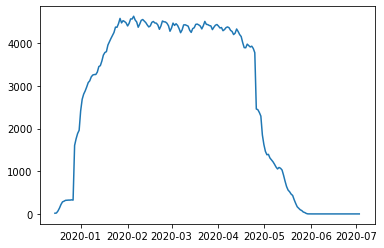

In [6]:
# No missingness in features if survey taken on a given day
# Number of survey datapoints per day (5.2k participants in total)
df_survey_model.timestamp.dt.date.value_counts().plot()

In [7]:
#Fill/mark missing days in between last and first day
missing_survey_rows = []

for participant in df_survey_model.participant_id.unique():
    date_vals = df_survey_model.loc[df_survey_model.participant_id == participant].timestamp.dt.date.values
    missing_dates = list(set(pd.date_range(date_vals.min(),date_vals.max()).date) - set(date_vals))
    
    for m_date in missing_dates:

        row_dict = dict.fromkeys(df_survey_model.columns,0)
        info_update = {'participant_id':participant, 'timestamp':m_date, 'trigger_datetime': None, 'missing_day': 1 }
        row_dict.update(info_update) 
        missing_survey_rows.append(row_dict)

df_survey_missing = pd.DataFrame(missing_survey_rows)               


In [9]:
window_size = 15
total_min_days_with_data = window_size
max_missing_days_window = int(window_size * 0.3)


train_cut_off_date = datetime.datetime.strptime('2020-2-01', '%Y-%m-%d')
valid_cut_off_date = datetime.datetime.strptime('2020-2-10', '%Y-%m-%d')


#Append dummy days
df_survey_model_ms_filled = df_survey_model.append(df_survey_missing)
df_survey_model_ms_filled.sort_values(by = ['timestamp'], inplace = True)


#List to iterate over
participant_list = df_survey_model_ms_filled.participant_id.unique()

#df_survey_training = 
#df_survey_validation = 

In [15]:
#Iterate over participants, pick window if missing days no more than win_size/n, link participants data across survey - activity - baseline

#fill missing for activity

print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

train_baseline_index = []
train_survey_x = []
train_y = []


validation_date_range = [d.date() for d in pd.date_range(train_cut_off_date, valid_cut_off_date - datetime.timedelta(days = 1))]

#Dictionary of lists, a list for every day which will be used to train and validate progressively
validation_survey_x = dict.fromkeys(validation_date_range,[])
validation_baseline_index = dict.fromkeys(validation_date_range,[])
validation_y = dict.fromkeys(validation_date_range,[])


for participant in participant_list:
    df_survey_participant = df_survey_model_ms_filled.loc[df_survey_model_ms_filled.participant_id == participant].reset_index(drop = True)
    if len(df_survey_participant) >= total_min_days_with_data:

            existing_dates = df_survey_participant.iloc[window_size-1:].loc[df_survey_participant.missing_day == 0].timestamp.values
            
            #flu negatives
            if df_survey_participant.trigger_datetime.isnull().min():
                training_dates = [date for date in existing_dates if date < train_cut_off_date]
                validation_dates = [date for date in existing_dates if date >= train_cut_off_date and date < valid_cut_off_date]
                
                for t_date in training_dates:
                    target_index = df_survey_participant.loc[df_survey_participant.timestamp == t_date].index.values[0]

                    cropped = df_survey_participant.iloc[target_index - window_size+1:target_index+1]


                    if cropped.missing_day.sum() <= max_missing_days_window:

                        train_baseline_index += [participant]
                        train_survey_x.append(cropped.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())

                        train_y += [0]


                for v_date in validation_dates:
                    target_index = df_survey_participant.loc[df_survey_participant.timestamp == v_date].index.values[0]
                    cropped = df_survey_participant.iloc[target_index - window_size+1:target_index+1]

                    if cropped.missing_day.sum() <= max_missing_days_window:

                        v_date = v_date.date()
                        validation_baseline_index[v_date] = validation_baseline_index[v_date] + [participant]
                        validation_survey_x[v_date] = validation_survey_x[v_date] + [cropped.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy()]
                        validation_y[v_date]  = validation_y[v_date] + [0]                
            
            #flu positives
            else:
                trigger_date = df_survey_participant.trigger_datetime.iloc[0]
                training_dates = [date for date in existing_dates if date < train_cut_off_date and date <= trigger_date]
                validation_dates = [date for date in existing_dates if (date >= train_cut_off_date and date < valid_cut_off_date and date <= trigger_date)]

                for t_date in training_dates:
                    target_index = df_survey_participant.loc[df_survey_participant.timestamp == t_date].index.values[0]

                    cropped = df_survey_participant.iloc[target_index - window_size+1:target_index+1]


                    if cropped.missing_day.sum() <= max_missing_days_window:

                        train_baseline_index += [participant]
                        train_survey_x.append(cropped.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())

                        if (cropped.iloc[-1].trigger_datetime.date() - cropped.iloc[-1].timestamp.date()).days == 0:
                            train_y += [1]
                        else:
                            train_y += [0]


                for v_date in validation_dates:
                    target_index = df_survey_participant.loc[df_survey_participant.timestamp == v_date].index.values[0]
                    cropped = df_survey_participant.iloc[target_index - window_size+1:target_index+1]

                    if cropped.missing_day.sum() <= max_missing_days_window:

                        v_date = v_date.date()
                        validation_baseline_index[v_date] = validation_baseline_index[v_date] + [participant]
                        validation_survey_x[v_date] = validation_survey_x[v_date] + [cropped.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy()]
                        
                        if (cropped.iloc[-1].trigger_datetime.date() - cropped.iloc[-1].timestamp.date()).days == 0:
                            validation_y[v_date] = validation_y[v_date] + [1]
                        else:
                            validation_y[v_date]  = validation_y[v_date] + [0]                    

print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 09:04:53
Current Time = 09:08:52


# Negative train samples
#Take crops of window size number of days which aren't necessarily consecutive
window_size = 15
train_cut_off_date = datetime.datetime.strptime('2020-2-01', '%Y-%m-%d')
valid_cut_off_date = datetime.datetime.strptime('2020-4-01', '%Y-%m-%d')


flu_negative_participants = df_survey_model.loc[df_survey_model.trigger_datetime.isnull()].sort_values('timestamp')

train_flu_negative_participants = flu_negative_participants.loc[flu_negative_participants.timestamp < train_cut_off_date]

neg_train_samples = []

for participant in train_flu_negative_participants.participant_id.unique():
    train_participant = train_flu_negative_participants.loc[train_flu_negative_participants.participant_id == participant].drop(columns = ['participant_id','trigger_datetime','timestamp'])
        
    if len(train_participant) >= window_size:
        for train_i in range(0,len(train_participant) - window_size + 1):
            #if (train_participant.iloc[train_i+window_size-1].timestamp.date() - train_participant.iloc[train_i].timestamp.date()).days == (window_size-1):
            neg_train_samples.append(train_participant.iloc[train_i:train_i+window_size].to_numpy())

neg_train_y = len(neg_train_samples) * [0]

#Flu positive train samples
#Only use up to trigger date. Take crops of window size number of days which aren't necessarily consecutive

flu_positive_participants = df_survey_model.loc[df_survey_model.trigger_datetime.notnull()].sort_values('timestamp')
train_flu_positive_participants = flu_positive_participants.loc[flu_positive_participants.timestamp < train_cut_off_date]

#Only using days up to the trigger date
train_flu_positive_participants = train_flu_positive_participants.loc[(train_flu_positive_participants.timestamp.dt.date - train_flu_positive_participants.trigger_datetime.dt.date).dt.days <= 0]

pos_train_samples = []
pos_train_y = []

for participant in train_flu_positive_participants.participant_id.unique():
    train_participant = train_flu_positive_participants.loc[train_flu_positive_participants.participant_id == participant]
    
    
    if len(train_participant) >= window_size:
        for train_i in range(0,len(train_participant) - window_size + 1):

            window_crop = train_participant.iloc[train_i:train_i+window_size]
            
            #y=1 if window ends with dx
            if (window_crop.iloc[window_size-1].trigger_datetime.date() - window_crop.iloc[window_size-1].timestamp.date()).days == 0:
                pos_train_samples.append(window_crop.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                pos_train_y += [1]
                break
            else:
                pos_train_samples.append(window_crop.drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                pos_train_y += [0]                



#Negative window crops for validation.

#Select particip with data before valid_cut_off date
valid_flu_negative_participants = flu_negative_participants.loc[(flu_negative_participants.timestamp < valid_cut_off_date)]

valid_participant_list = valid_flu_negative_participants.loc[valid_flu_negative_participants.timestamp >= train_cut_off_date].participant_id.unique()


#Last day inclusive range
valid_date_range = pd.date_range(train_cut_off_date, valid_cut_off_date - datetime.timedelta(days = 1))

#List of lists, a list for every day which will be used to train and validate progressively
valid_samples = [[] for _ in valid_date_range]
valid_y = [[] for _ in valid_date_range]

#Iterate over participants
for participant in valid_participant_list:
    valid_participant = valid_flu_negative_participants.loc[valid_flu_negative_participants.participant_id == participant]
    valid_participant.reset_index(drop = True, inplace = True)
    
    #for each participant iterate over date range, find the index of given date and take -window_size
    for i in range(len(valid_date_range)):
        valid_date = valid_date_range[i]
        #find index of row with the given validation date
        date_index = valid_participant.index[valid_participant['timestamp'].dt.date == valid_date.date()]
        
        #if data for given day exists, take all leading days and crop a window
        if len(date_index) != 0:
            valid_crop = valid_participant.iloc[:date_index[0]+1]
            
            if len(valid_crop) >= window_size:
                valid_samples[i].append(valid_crop.iloc[-window_size:].drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                valid_y[i].append(0)
                
                
            

#Positive window crops for validation.

#Select particip with data before valid_cut_off date
valid_flu_positive_participants = flu_positive_participants.loc[(flu_positive_participants.timestamp < valid_cut_off_date)]

valid_participant_list = valid_flu_positive_participants.loc[(valid_flu_positive_participants.timestamp >= train_cut_off_date) & (valid_flu_positive_participants.trigger_datetime >= train_cut_off_date)].participant_id.unique()


#Iterate over participants
for participant in valid_participant_list:
    valid_participant = valid_flu_positive_participants.loc[valid_flu_positive_participants.participant_id == participant]
    valid_participant.reset_index(drop = True, inplace = True)
    
    #for each participant iterate over date range, find the index of given date and take -window_size
    for i in range(len(valid_date_range)):
        valid_date = valid_date_range[i]
        date_index = valid_participant.index[valid_participant['timestamp'].dt.date == valid_date.date()]
        
        #if data for given day exists, take all leading days and crop a window
        if len(date_index) != 0:
            valid_crop = valid_participant.iloc[:date_index[0]+1]
            
            if len(valid_crop) >= window_size:
                
                #y=1 if window ends with dx
                if (valid_date.date() - valid_crop.iloc[-1].trigger_datetime.date()).days == 0:
                    
                    valid_samples[i].append(valid_crop.iloc[-window_size:].drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                    valid_y[i].append(1)
                    break
                    
                else:
                    valid_samples[i].append(valid_crop.iloc[-window_size:].drop(columns = ['participant_id','trigger_datetime','timestamp']).to_numpy())
                    valid_y[i].append(0)
 

In [728]:
#Convert survey data to np arrays. Train valid already split temporally.
train_survey_x_stacked = np.stack((train_survey_x))
train_y  = np.array(train_y)

validation_y_list = []
validation_survey_x_list = []

for key in validation_survey_x.keys():
    validation_survey_x_list += [np.stack(validation_survey_x[key])]
    validation_y_list += [np.array(validation_y[key])]

In [729]:
#Scale survey train data
n_timesteps = train_survey_x_stacked.shape[1]
n_features = train_survey_x_stacked.shape[2]

X_train = train_survey_x_stacked
y_train = train_y
X_train_scaled = X_train

survey_scalers = {}
for i in range(n_features):
    survey_scalers[i] = MinMaxScaler()
    X_train_scaled[:, :, i] = survey_scalers[i].fit_transform(X_train[:, :, i]) 

In [730]:
#participant ids to indices to link surveys and baselines
train_b_ind = []
for p in train_baseline_index:
    train_b_ind += [df_baseline.loc[df_baseline.participant_id == p].index.values[0]]
    
valid_b_ind = []

for key in validation_baseline_index.keys():
    ind_for_day = []
    for p in validation_baseline_index[key]:
        ind_for_day += [df_baseline.loc[df_baseline.participant_id == p].index.values[0]]
    valid_b_ind += [ind_for_day]

In [731]:
#Baseline data prepared for modelling
baseline_array = df_baseline.drop(['participant_id','Unnamed: 0'],axis=1).to_numpy()

baseline_scaled = baseline_array
scaler = MinMaxScaler()
baseline_scaled = scaler.fit_transform(baseline_array)  

pca = PCA(.95)
pca.fit(baseline_scaled)
baseline_pca = pca.transform(baseline_scaled)

In [732]:
baseline_pca.shape

(5229, 136)

In [733]:
def create_cnn(n_timesteps, n_features):
    model = keras.Sequential()
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'same' ,input_shape=(n_timesteps,n_features)))
    model.add(layers.BatchNormalization())
    #model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu',padding = 'same'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu',padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    #pooling
    #dropout
    #batch training
    model.add(layers.GlobalAveragePooling1D())

    
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
    
    return model

In [734]:
def create_lstm(n_timesteps, n_features):
    model = keras.Sequential()
    model.add(layers.LSTM(64, input_shape=(n_timesteps, n_features)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

    return model

model_survey.summary()

m2 = keras.Model(inputs=model_survey.input, outputs=model_survey.layers[6].output)
Y = m2(X_train_scaled)
Y.numpy()

In [735]:
#Train survey based model to learn repr.
epochs = 10
minority_weight = len(y_train)/sum(y_train)

model_survey  = create_lstm(n_timesteps, n_features)

shuffled_X_train, shuffled_y_train = shuffle(X_train_scaled, y_train, random_state = 42)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

model_survey.fit(shuffled_X_train, shuffled_y_train, class_weight = {1: minority_weight, 0: 1}, epochs=epochs, validation_split=0.15, callbacks = [early_stopping_monitor], verbose=1)


Epoch 1/10
1622/1622 [==============================] - 11s 6ms/step - loss: 1.4909 - accuracy: 0.8806 - auc_38: 0.7920 - recall_38: 0.7308 - precision_38: 0.0031 - val_loss: 0.1271 - val_accuracy: 0.9809 - val_auc_38: 0.9981 - val_recall_38: 1.0000 - val_precision_38: 0.0223
Epoch 2/10
1622/1622 [==============================] - 10s 6ms/step - loss: 0.0988 - accuracy: 0.9827 - auc_38: 0.9979 - recall_38: 1.0000 - precision_38: 0.0281 - val_loss: 0.0311 - val_accuracy: 0.9904 - val_auc_38: 0.9990 - val_recall_38: 1.0000 - val_precision_38: 0.0435
Epoch 3/10
1622/1622 [==============================] - 10s 6ms/step - loss: 0.0490 - accuracy: 0.9899 - auc_38: 0.9987 - recall_38: 1.0000 - precision_38: 0.0474 - val_loss: 0.0166 - val_accuracy: 0.9954 - val_auc_38: 0.9988 - val_recall_38: 1.0000 - val_precision_38: 0.0870
Epoch 4/10
1622/1622 [==============================] - 10s 6ms/step - loss: 0.0383 - accuracy: 0.9936 - auc_38: 0.9987 - recall_38: 1.0000 - precision_38: 0.0728 - val_

In [736]:
#Get representations, mind the output layer
trained_model = keras.Model(inputs=model_survey.input, outputs=model_survey.layers[-2].output)
survey_representations = trained_model(X_train_scaled).numpy()

#Scale survey representations
survey_rep_scaler = MinMaxScaler()
survey_representations_scaled = survey_rep_scaler.fit_transform(survey_representations)

#(n of windows, features) array participant baselines corresponding to each time window
train_baseline = np.take(baseline_pca,train_b_ind,axis = 0)

#Combine survey and baseline data into a single array
train_baseline_survey = np.concatenate((survey_representations_scaled,train_baseline),axis = 1)



In [737]:
#Train end classifier
#rfc = RandomForestClassifier(n_estimators=100000,max_depth=10)
log = LogisticRegression(solver='lbfgs', class_weight='balanced',max_iter = 1000)
xgb_classif = xgb.XGBClassifier(scale_pos_weight = minority_weight, n_estimators=100, colsample_bytree = 0.3, learning_rate = 0.05,max_depth = 10, alpha = 10, verbosity = 0)

end_classifier = xgb_classif
end_classifier.fit(train_baseline_survey,y_train)



XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=2034.5666666666666,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [738]:
# 'makul' bi model ortaya ciksin onu variantlarini seri train et
#diger yandan aksam ustu mutlaka day level data'yi da buraya dahil etme operasyonu cek
#ideally day level entegrasyonu bugun biter, ama worst case yarin kesin bitmis olsun 
#en azindan pazar minute level calisayim, proxy task degisimine bakarim

#scaling isinde sikinti var buyuk ihtimalle

In [739]:
#Train & valid loop
avg_auc_preds = []
avg_auc_prob = []
avg_acc = []
avg_f1 = []
avg_recall = []
avg_precision = []
avg_f_1_score = []

survey_TN = 0
survey_FN = 0
survey_TP = 0
survey_FP = 0

avg_auc_preds_combined = []
avg_auc_prob_combined = []

avg_acc_combined = []
avg_auc_combined = []
avg_f1_combined = []
avg_recall_combined = []
avg_precision_combined = []
avg_f_1_score_combined = []

combined_TN = 0
combined_FN = 0
combined_TP = 0
combined_FP = 0

#Scaling issue!
survey_scalers = {}
for i in range(n_features):
    survey_scalers[i] = MinMaxScaler()
    survey_scalers[i].fit(X_train[:, :, i]) 
    X_train_scaled[:, :, i] = survey_scalers[i].transform(X_train[:, :, i]) 


for i in range(len(validation_survey_x_list)):
    
    #Predict
    daily_batch_X = validation_survey_x_list[i]
    daily_batch_y = validation_y_list[i]
    
    scaled_daily_batch_X = daily_batch_X
    for feat in range(n_features):
        scaled_daily_batch_X[:, :, feat] = scalers[feat].transform(daily_batch_X[:, :, feat]) 

    
    survey_preds = model_survey.predict_classes(scaled_daily_batch_X, verbose=0)
    survey_prob = model_survey.predict(scaled_daily_batch_X, verbose=0)
    
    roc_auc_preds = roc_auc_score(daily_batch_y,survey_preds)
    roc_auc_prob = roc_auc_score(daily_batch_y,survey_prob)
    
    acc = accuracy_score(daily_batch_y,survey_preds)
    precision = precision_score(daily_batch_y,survey_preds)
    recall = recall_score(daily_batch_y,survey_preds)
    f_1_score = f1_score(daily_batch_y,survey_preds)
    
    avg_auc_preds += [roc_auc_preds]
    avg_auc_prob += [roc_auc_prob]
  
    avg_acc += [acc]
    avg_precision += [precision]
    avg_recall += [recall]
    avg_f_1_score += [f_1_score]
    
    survey_CM = confusion_matrix(daily_batch_y, survey_preds)

    survey_TN += survey_CM[0][0]
    survey_FN += survey_CM[1][0]
    survey_TP += survey_CM[1][1]
    survey_FP += survey_CM[0][1]

    print("survey pred based AUC: ", roc_auc_preds)
    print("survey proba based AUC: ", roc_auc_prob)
    print(survey_CM)

    #Get representations, mind the output layer
    representations_model = keras.Model(inputs=model_survey.input, outputs=model_survey.layers[-2].output)
    daily_survey_representations = representations_model(scaled_daily_batch_X).numpy()

    #Scale survey representations
    daily_survey_representations_scaled = survey_rep_scaler.transform(daily_survey_representations)

    #(n of windows, features) array participant baselines corresponding to each time window
    daily_baseline = np.take(baseline_pca,valid_b_ind[i],axis = 0)

    #Combine survey and baseline data into a single array
    daily_baseline_survey = np.concatenate((daily_survey_representations_scaled,daily_baseline),axis = 1)
    
    #Classify
    combined_preds = end_classifier.predict(daily_baseline_survey)
    combined_prob = end_classifier.predict_proba(daily_baseline_survey)

    roc_auc_preds = roc_auc_score(daily_batch_y,combined_preds)
    roc_auc_prob = roc_auc_score(daily_batch_y,combined_prob[:,1])
    
    acc = accuracy_score(daily_batch_y,combined_preds)
    precision = precision_score(daily_batch_y,combined_preds)
    recall = recall_score(daily_batch_y,combined_preds)
    f_1_score = f1_score(daily_batch_y,combined_preds)
 
    avg_auc_preds_combined += [roc_auc_preds]
    avg_auc_prob_combined += [roc_auc_prob]

    avg_auc_combined += [roc_auc]
    avg_acc_combined += [acc]
    avg_precision_combined += [precision]
    avg_recall_combined += [recall]
    avg_f_1_score_combined += [f_1_score]
    
    combined_CM = confusion_matrix(daily_batch_y, combined_preds)

    combined_TN += combined_CM[0][0]
    combined_FN += combined_CM[1][0]
    combined_TP += combined_CM[1][1]
    combined_FP += combined_CM[0][1]
   
    print("combined pred based AUC: ", roc_auc_preds)
    print("combined proba based AUC: ", roc_auc_prob)
    print(combined_CM) 
    
    #Train
    #X_train, y_train = shuffle(np.concatenate((X_train,daily_batch_X)), np.append(y_train,daily_batch_y), random_state = 42)
    
    """
    scalers = {}
    for j in range(n_features):
        scalers[j] = StandardScaler()
        scalers[j].fit(X_train[:, :, j]) 
        scaled_daily_batch_X[:, :, j] = scalers[j].transform(daily_batch_X[:, :, j])
        
    """
    shuffled_X, shuffled_y= shuffle(scaled_daily_batch_X, daily_batch_y, random_state = 42)
    model_survey.fit(shuffled_X, shuffled_y, class_weight = {1: minority_weight, 0: 1}, epochs=1, verbose=0)
    
    #Get representations, mind the output layer
    representations_model = keras.Model(inputs=model_survey.input, outputs=model_survey.layers[-2].output)
    daily_survey_representations = representations_model(scaled_daily_batch_X).numpy()

    #Scale survey representations
    daily_survey_representations_scaled = survey_rep_scaler.transform(daily_survey_representations)


    #(n of windows, features) array participant baselines corresponding to each time window
    daily_baseline = np.take(baseline_pca,valid_b_ind[i],axis = 0)

    #Combine survey and baseline data into a single array
    daily_baseline_survey = np.concatenate((daily_survey_representations_scaled,daily_baseline),axis = 1)
    
    #Train end-classif.
    end_classifier.fit(daily_baseline_survey, daily_batch_y)


survey_acc = (survey_TP + survey_TN) / (survey_TP + survey_TN + survey_FP + survey_FN)
survey_precision = survey_TP/(survey_TP+survey_FP)
survey_recall = survey_TP/(survey_TP+survey_FN)
survey_f1_score = (2*survey_precision*survey_recall)/(survey_precision+survey_recall)

print("\n Average pred AUC: ", sum(avg_auc_preds)/len(avg_auc_preds))
print("\n Average prob AUC: ", sum(avg_auc_prob)/len(avg_auc_prob))

print("\n Overall survey accuracy: ", survey_acc)    
print("\n Overall survey precision: ", survey_precision)    
print("\n Overall survey recall: ", survey_recall)    
print("\n Overall survey f-1 score: ", survey_f1_score)    

combined_acc = (combined_TP + combined_TN) / (combined_TP + combined_TN + combined_FP + combined_FN)
combined_precision = combined_TP/(combined_TP+combined_FP)
combined_recall = combined_TP/(combined_TP+combined_FN)
combined_f1_score = (2*combined_precision*combined_recall)/(combined_precision+combined_recall)

print("\n Average pred combined AUC: ", sum(avg_auc_preds_combined)/len(avg_auc_preds_combined))    
print("\n Average prob combined AUC: ", sum(avg_auc_prob_combined)/len(avg_auc_prob_combined))    

print("\n Overall combined accuracy: ", combined_acc)    
print("\n Overall combined precision: ", combined_precision)    
print("\n Overall combined recall: ", combined_recall)    
print("\n Overall combined f-1 score: ", combined_f1_score)    

print('\n Survey conf mat\n',survey_TN,'|',survey_FP,'\n',survey_FN,'|',survey_TP,'\n')
print('\n Combined conf mat\n',combined_TN,'|',combined_FP,'\n',combined_FN,'|',combined_TP,'\n')


survey pred based AUC:  0.5690924416971059
survey proba based AUC:  0.43506602978364717
[[3339  220]
 [   4    1]]
combined pred based AUC:  0.4998595110986232
combined proba based AUC:  0.6692891261590334
[[3558    1]
 [   5    0]]
survey pred based AUC:  0.9960511982570806
survey proba based AUC:  0.9982298474945535
[[3643   29]
 [   0    2]]
combined pred based AUC:  0.9991830065359477
combined proba based AUC:  1.0
[[3666    6]
 [   0    2]]
survey pred based AUC:  0.6632238700564971
survey proba based AUC:  0.3404837570621469
[[3750   26]
 [   2    1]]
combined pred based AUC:  0.4997351694915254
combined proba based AUC:  0.6513947740112993
[[3774    2]
 [   3    0]]
survey pred based AUC:  0.6635079406861454
survey proba based AUC:  0.9778450469421778
[[3775   24]
 [   4    2]]
combined pred based AUC:  0.5
combined proba based AUC:  0.9889005878740019
[[3799    0]
 [   6    0]]


/homes/gws/melih/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


survey pred based AUC:  0.9938822329849605
survey proba based AUC:  0.9963463335882403
[[3875   48]
 [   0    6]]
combined pred based AUC:  0.6651372249129067
combined proba based AUC:  0.9943495624097205
[[3911   12]
 [   4    2]]
survey pred based AUC:  0.8937911809427268
survey proba based AUC:  0.995793208312215
[[3897   49]
 [   1    4]]
combined pred based AUC:  0.7992397364419666
combined proba based AUC:  0.9960973137354283
[[3940    6]
 [   2    3]]
survey pred based AUC:  0.7937779990044799
survey proba based AUC:  0.9884519661523147
[[3968   50]
 [   2    3]]
combined pred based AUC:  0.5990044798407167
combined proba based AUC:  0.9934295669487307
[[4010    8]
 [   4    1]]
survey pred based AUC:  0.8269784782240298
survey proba based AUC:  0.8756566683612947
[[3884   50]
 [   2    4]]
combined pred based AUC:  0.4991103202846975
combined proba based AUC:  0.9894085748178275
[[3927    7]
 [   6    0]]
survey pred based AUC:  0.8677770859277708
survey proba based AUC:  0.993